<a href="https://colab.research.google.com/github/SupermarketAutomationAI/baseline_model_SVM/blob/main/baseline_model_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading, Splitting, and Preprocessing

## Load the Data

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip '/content/drive/My Drive/APS360 Project/Dataset Zip Files/SupermarketAutomationAI_Dataset_V1' -d '/root/datasets'

## Split the data

In [3]:
# Import the necessary libraries
import json
import os
import math
import shutil

In [8]:
# create data directory and move all images into it
parent_dir = "/root/datasets/SupermarketAutomationAI_Dataset_V1"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

FileExistsError: ignored

In [5]:
train_split = 0.6

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
 path = parent_dir + '/'+ dsdirs
 os.mkdir( path,755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)

## Preprocess data into Dataloaders

In [6]:
# Remove hidden files & directories that break data loader
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  !find $path -name '._*' -delete
  print("Deleted ._* files from {0}".format(path))

Deleted ._* files from /root/datasets/SupermarketAutomationAI_Dataset_V1/train
Deleted ._* files from /root/datasets/SupermarketAutomationAI_Dataset_V1/val
Deleted ._* files from /root/datasets/SupermarketAutomationAI_Dataset_V1/test


In [26]:
# import needed libraries for this section
import torch
from torchvision import datasets, transforms

In [27]:
# set the batch_size
batch_size = 64

# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')

# define a list of all classes that the model will be trained with

# List different classes: 14 currently
classes = ['Multiple Bananas', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Golden Delicious Apples', 
           'Multiple Granny Smith Apples', 'Multiple Oranges', 'Multiple Red Delicious Apples',
           'One Banana', 'One Fuji Apple', 'One Gala Apple', 'One Golden Delicious Apple',
           'One Granny Smith Apple', 'One Orange', 'One Red Delicious Apple']

# three possible transforms, will test each to see which gives better results
data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  6945
Amount of validation data:  2310
Amount of test data:  2273


# Model Building, Training, and Testing

In [28]:
# imports
import numpy as np
import time
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn import svm

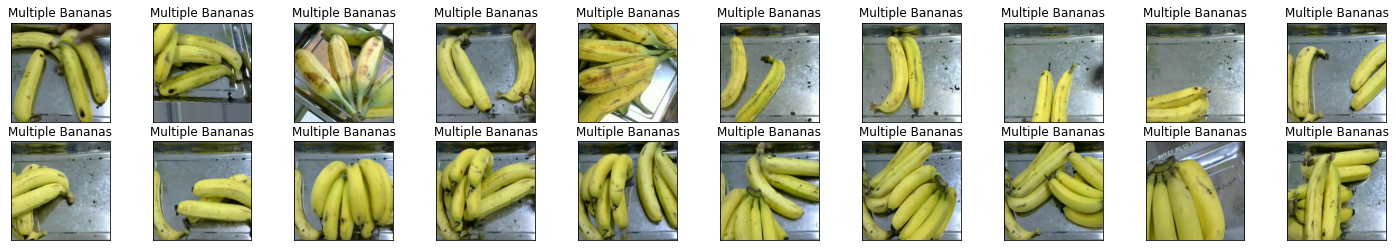

In [29]:
# Verification Step - obtain one batch of images ## from lab
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [30]:
# Save features
batch_size = 1
num_workers = 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# save feature with just flattening
n = 0
for img, label in train_loader:
  features = img.flatten()
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = parent_dir + '/train/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in val_loader:
  features = img.flatten()
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = parent_dir + '/val/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in val_loader:
  features = img.flatten()
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = parent_dir + '/test/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

In [ ]:
# or save features with Alexnet
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

n = 0
for img, label in train_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = parent_dir + '/train/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in val_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = parent_dir + '/val/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in val_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = parent_dir + '/test/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1


In [31]:
# Load Tensor Files (features) from folder
trainset = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.tensor'))
valset = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.tensor'))
testset = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.tensor'))

In [34]:
batch_size = 1024   # 6000 close to entire train dataset, run out of memory if this is too big when using just flattened features
num_workers = 1
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [33]:
def get_accuracy(model, d_loader):
    dataiter = iter(d_loader)
    images, labels = dataiter.next()
    images = images.reshape(images.shape[0], -1)
    acc = model.score(images, labels)
    return acc

In [35]:
clf = svm.SVC(kernel='poly')

dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images.reshape(images.shape[0], -1)
clf.fit(images, labels)

print(clf.score(images, labels))
val_acc = get_accuracy(clf, val_loader)
print(val_acc)


0.9990234375
0.798828125
